# DC Target

[Lindsey Heagy](http://github.com/lheagy)

SimPEG and the implementation for electrical and electromagnetic methods is described in ([Cockett et al., 2015](https://doi.org/10.1016/j.cageo.2015.09.015) and [Heagy et al., 2017](https://arxiv.org/abs/1610.00804)).

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipywidgets
from string import ascii_lowercase
from matplotlib import rcParams, ticker
from matplotlib import patches

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

In [2]:
include_offset = False  # include models with a gap between the casing and target
offset_only = False  # run only the examples with the gap between the casing and the target
include_uncased = False  # include a suite of models without casing

##  Parameters

In [3]:
simDir = 'DC_target'  # create a simulation directory where results can be saved. 

In [4]:
casing_l = 1000
sigma_back = 1e-1
casing_d = 10e-2 #10cm diameter
casing_t = 1e-2 #1cm thickness
sigma_target = sigma_back
target_r = np.r_[0, 25.]
target_z = np.r_[-925., -900.]

model = casingSim.model.CasingInHalfspaceWithTarget(
    directory=simDir,
    sigma_casing= 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 10 cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    target_radius = target_r,
    target_z = target_z,
    src_a = np.r_[0., np.pi, -1.25],  # put the A electrode just below the surface
    src_b = np.r_[500., np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, np.pi, -1.25]  

In [5]:
# Here we print the parameters being used to set up the simulation
model.serialize()

{'__class__': 'CasingInHalfspaceWithTarget',
 'casing_d': 0.09000000000000001,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': 'DC_target',
 'filename': 'ModelParameters.json',
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'sigma_air': 0.0001,
 'sigma_back': 0.1,
 'sigma_casing': 5000000.0,
 'sigma_inside': 0.1,
 'sigma_target': 0.01,
 'src_a': [0.045000000000000005, 3.141592653589793, -1.25],
 'src_b': [500.0, 3.141592653589793, -1.25],
 'surface_z': 0.0,
 'target_radius': [0.0, 25.0],
 'target_theta': [0.0, 6.283185307179586],
 'target_z': [-925.0, -900.0],
 'version': '0.0.6'}

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [6]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 1000  # go out 500m from the well

# padding parameters
npadx, npadz = 8, 15  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# discretization in theta
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(16)
hy = hy*2*np.pi / hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx1=1.2, 
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


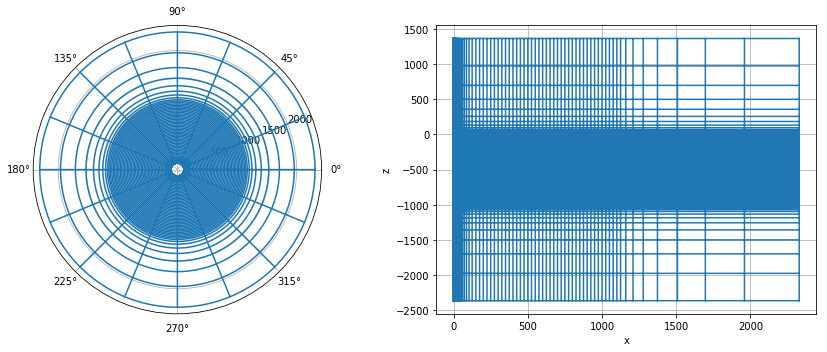

In [7]:
cylMeshGen.mesh.plotGrid()

In [8]:
src_theta = np.pi + hy[0]/2.

model.src_a[1] = src_theta
model.src_b[1] = src_theta

(0.0, 3000.0)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


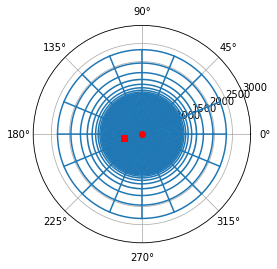

In [9]:
# Plot the source location

ax = plt.subplot(111, projection='polar')
cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
ax.plot(model.src_a[1], model.src_a[0], 'ro')
ax.plot(model.src_b[1], model.src_b[0], 'rs')
ax.set_ylim([0., 3*model.casing_l])

In [10]:
# put the models in a dictionary for convienence 

# target_sigma = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
target_sigma = [1e0]

if offset_only:
    model_names = ["target_{:1.0e}".format(sig) for sig in [sigma_back]]
#     target_sigma = [sigma_back]
else: 
    model_names = ["target_{:1.0e}".format(sig) for sig in target_sigma]

model_names_offset = ["offset_{:1.0e}".format(sig) for sig in target_sigma if sig != sigma_back]
# model_names_offset2 = ["offset2_{:1.0e}".format(sig) for sig in target_sigma if sig != sigma_back]
# model_names_offset3 = ["offset3_{:1.0e}".format(sig) for sig in target_sigma if sig != sigma_back]

if include_uncased:
    model_names_uncased = ["uncased_{:1.0e}".format(sig) for sig in target_sigma]

modelDict = {}

for name, sig in zip(model_names, target_sigma if not offset_only else [sigma_back]):
    tmp_model = model.copy()
    tmp_model.sigma_target = sig
    modelDict[name] = tmp_model

if include_offset: 
    for name, sig in zip(model_names_offset, [sig for sig in target_sigma if sig != sigma_back]):
        tmp_model = model.copy()
        tmp_model.sigma_target = sig
        tmp_model.target_radius = np.r_[tmp_model.casing_b + tmp_model.casing_t, 25.]
        modelDict[name] = tmp_model

    
#     for name, sig in zip(model_names_offset2, [sig for sig in target_sigma if sig != sigma_back]):
#         tmp_model = model.copy()
#         tmp_model.sigma_target = sig
#         tmp_model.target_radius = np.r_[tmp_model.casing_b + 1e-1, 25.]
#         modelDict[name] = tmp_model
    
#     for name, sig in zip(model_names_offset3, [sig for sig in target_sigma if sig != sigma_back]):
#         tmp_model = model.copy()
#         tmp_model.sigma_target = sig
#         tmp_model.target_radius = np.r_[tmp_model.casing_b + 1, 25.]
#         modelDict[name] = tmp_model


    model_names += model_names_offset 
#     model_names += model_names_offset2
#     model_names += model_names_offset3

if include_uncased:
    copiedmodelparams = {
        key: val for key, val in model.serialize().items() 
        if key in dir(casingSim.model.TargetInHalfspace) and not key.startswith('_') 
    }
    for name, sig in zip(model_names_uncased, target_sigma):
        tmp_model = casingSim.model.TargetInHalfspace(
            **copiedmodelparams
        )
        tmp_model.sigma_target = sig
        modelDict[name] = tmp_model
    model_names += model_names_uncased
    
modelDict

{'target_1e+00': <casingSimulations.model.CasingInHalfspaceWithTarget at 0xd19436908>}

In [11]:
modelDict['target_1e-01'].sigma_target

KeyError: 'target_1e-01'

In [ ]:
# Assign physical properties on the mesh
physpropsDict = {
    key: casingSim.model.PhysicalProperties(cylMeshGen, modelDict[key]) 
    for key in model_names
}

In [ ]:
# Plot the models
xlim = 30*np.r_[-1, 1]  # x-limits in meters
# zlim = np.r_[-1.5*model.casing_l, 10.]  # z-limits in meters. (z-positive up)
zlim = np.r_[-1000, -800]

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
if len(model_names) == 1:
    ax=[ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{}'.format(title), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

## Source locations

In [ ]:
model.target_z

In [ ]:
# Set up 4 sources, top casing, top & not coupled, downhole, downhole not coupled

src_a = np.vstack([
    [model.casing_r, src_theta, -1.25],
    [model.casing_r, src_theta, model.target_z.mean()],
])

src_b = np.ones((src_a.shape[0],1)) * model.src_b

src_names = [
    "top casing",
    "downhole",
]

## set up a DC simulation

In [ ]:
simDict = {}
for title in model_names:
    if title not in simDict.keys():
        simDict[title] = casingSim.run.SimulationDC(
            modelParameters=modelDict[title], directory=simDir, 
            meshGenerator=cylMeshGen, src_a=src_a, src_b=src_b
        )


In [ ]:
%%time
fieldsDict = {}
for title in model_names:
    if title not in fieldsDict.keys():
        print('--- Running {} ---'.format(title))
        fieldsDict[title] = simDict[title].run()
        print('\n')

## Plot Results

Here we plot the radial electric field along a line $90^{\circ}$ from the source. 

In [ ]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, 
    primary_key=(
        "uncased_{:1.0e}".format(sigma_back) if include_uncased else 
        "target_{:1.0e}".format(sigma_back) 
    ),
    model_keys=model_names
)

In [ ]:
viewer.widget_cross_section()

In [ ]:
mesh = cylMeshGen.mesh

In [ ]:
def excitation(key, src_ind=0, primary_key='target_1e-01'):
    primary_src = simDict[primary_key].survey.srcList[src_ind]
    
    ep = fieldsDict[primary_key][primary_src, 'e']
    ep = mesh.aveF2CCV * ep
    
    dim = int(len(ep)/mesh.nC)
    
    e = [discretize.utils.mkvc(ep[i*mesh.nC:(i+1)*mesh.nC]) for i in range(dim)] 

    sigma_sec = discretize.utils.mkvc(physpropsDict[key].sigma - physpropsDict[primary_key].sigma)

    j = [sigma_sec*ei for ei in e]
    jV = [mesh.vol * ji for ji in j]
    J = [np.sum(ji) for ji in jV]

    return np.sqrt(np.sum([Ji**2 for Ji in J]))

In [ ]:
for key in model_names:
    print("{}, top-hole source: {:1.2f}, down-hole source: {:1.2f}".format(key, excitation(key, src_ind=0), excitation(key, src_ind=1)))
#     print(key, excitation(key))

In [ ]:
for key in model_names:
    print("{} & {:1.2e} & {:1.2e} \\\\".format(key, excitation(key, src_ind=1), excitation(key, src_ind=0)))
#     print(key, excitation(key))

In [ ]:
cylMeshGen.modelParameters = modelDict[model_names[0]]

In [ ]:
rcParams['font.size'] = 14

In [ ]:
if include_uncased: 
    keys = ['uncased_{:1.0e}'.format(sig) for sig in [1e1, 1e-3]]
    fig, ax = plt.subplots(len(keys), 4, figsize=(4*3.5,len(keys)*5))

    fig.subplots_adjust(bottom=0.1)

    src_ind = 1
    theta_ind = 4

    max_r = 70
    min_depth = 825
    max_depth = 1025

    zlim = np.r_[-max_depth, -min_depth]
    xlim = max_r * np.r_[-1., 1.]
    stream_opts = {"color":"k", "arrowsize":1.5}

    for i, key in enumerate(keys):

        sigma_out = viewer.plot_cross_section(
            ax=ax[i][0], 
            clim=np.r_[1e-3, 1e7],
            xlim=xlim, 
            zlim=zlim,
            view='sigma', 
            theta_ind=theta_ind, 
            model_key=key, 
            show_cb=False, 
            use_aspect=True,
            casing_outline=False,
            stream_opts=stream_opts,
            src_ind=src_ind
        )
        ax[i][0].text(
            max_r - 2, -max_depth+10, 
            "target: {:1.0e} S/m".format(float(key.split("_")[-1])), 
            color='w', fontsize=20, horizontalalignment="right"
        )

        currents_out = viewer.plot_cross_section(
            ax=ax[i][1], 
            clim= np.r_[1e-6, 1e-3],
            xlim=xlim, 
            zlim=zlim,
            view='j', 
            theta_ind=theta_ind, 
            model_key=key, 
            show_cb=False, 
            use_aspect=True,
            casing_outline=False,
            cb_extend='bottom',
            stream_opts=stream_opts,
            src_ind=src_ind
        )

        charge_out = viewer.plot_cross_section(
            ax=ax[i][2], 
            clim= 2e-14 * np.r_[-1, 1] if key.startswith("uncased") else 2e-15 * np.r_[-1, 1],
            xlim=xlim, 
            zlim=zlim,
            view='charge_density', 
    #         prim_sec='secondary',
            theta_ind=theta_ind, 
            model_key=key, 
            show_cb=False, 
            use_aspect=True,
            casing_outline=False,
            stream_opts=stream_opts,
            src_ind=src_ind
        )

        efields_out = viewer.plot_cross_section(
            ax=ax[i][3], 
            clim= np.r_[1e-5, 1e-1] if key.startswith("uncased") else np.r_[1e-5, 1e-2],
            xlim=xlim, 
            zlim=zlim,
            view='e', 
            theta_ind=theta_ind, 
            model_key=key, 
            show_cb=False, 
            use_aspect=True,
            casing_outline=False,
            cb_extend='bottom',
            stream_opts=stream_opts,
            src_ind=src_ind
        )

        if i == 0: 
            for j, a in enumerate(ax[i]):
                a.set_xticklabels(['']*len(a.get_xticklabels()))
                a.set_xlabel('')
                a.set_ylabel('z (m)')
                a.set_title('({})'.format(ascii_lowercase[j]))
                if j > 0:
                    a.set_yticklabels(['']*len(a.get_xticklabels()))
                    a.set_ylabel('')
        else:
            for j, a in enumerate(ax[i]):
                a.set_xlabel('x (m)')
                a.set_title('')
                a.set_ylabel('z (m)')
                if j > 0:
                    a.set_yticklabels(['']*len(a.get_xticklabels()))
                    a.set_ylabel('')

    #     for a in ax[i]:
    #         plt.plot()


    # cbar_ax = fig.add_axes([0.25, -0.01, 0.11, 0.01])
    # cb_charge = fig.colorbar(charge_out[0], ax=cbar_ax, orientation='horizontal')

    plt.tight_layout()

    for i, out, label in zip(
        np.arange(4), 
        [sigma_out, currents_out, charge_out, efields_out],
        ['conductivity (S/m)', 'current density (A/m$^2$)', 'charge \n density (C/m$^3$)', 'electric field (V/m)'],
    #     [None, None, 'min', 'min']
    ):
        x = ax[1][i].figbox.corners()[0, 0]
        cbar_ax = fig.add_axes([x+0.025, -0.01, 0.175, 0.015])
        cb = fig.colorbar(
            out[0], cbar_ax, orientation="horizontal"
        )
        cb.set_label(label)
        cb.set_ticks([cb.vmin, cb.vmax])
        cb.update_ticks()

    plt.show() 

    fig.savefig('../figures/uncased_target_physics', bbox_inches="tight")

In [ ]:
model_names

In [ ]:
def plot_charge(
    ax=None, key=model_names[0], color_ind=0, color=None, src_ind=0, 
    label=None, secondary=False, linestyle='-', primary_key="target_1e-01",
    marker=None, ratio=False, radius=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 4)) #, dpi=400)
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]    
    plotme = f[src, 'charge']
    mod = modelDict[key].copy()
    
    if radius is not None:
        mod.casing_d = radius * 2
    
    if secondary is True or ratio is True:
        f_prim = fieldsDict[primary_key]
        src_prim = simDict[primary_key].survey.srcList[src_ind]
        if secondary is True: 
            plotme = plotme - f_prim[src_prim, 'charge']
        elif ratio is True:
            plotme = plotme/(f_prim[src_prim, 'charge'] + 1e-30)
    z_charges, charges = casingSim.casing_charges(plotme, mesh, mod)
#     print(key, sum(charges))
    ax.plot(
        -z_charges, charges/csz, label=label, 
        color=color if color is not None else "C{}".format(color_ind), 
        linestyle=linestyle, marker=marker
    )
        

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi = 350)

primary_key = "target_1e-01"
src_ind = 0
xlim = np.r_[0, 1000]

plot_charge(
    ax=ax[0], key=primary_key, color = "k", src_ind=src_ind, label=key
)

plot_sigma = [sig for sig in target_sigma if sig != 0.1]
for i, sig in enumerate(plot_sigma):
    target_key = "target_{:1.0e}".format(sig)
    offset_key = "offset_{:1.0e}".format(sig)
    offset2_key = "offset2_{:1.0e}".format(sig)
    offset3_key = "offset3_{:1.0e}".format(sig)

    plot_charge(
        ax=ax[0], key=target_key, color_ind=i, src_ind=src_ind, label="{} m".format(sig)
    )
    plot_charge(
        ax=ax[0], key=offset_key, color_ind=i, src_ind=src_ind, linestyle='--'
    )
    plot_charge(
        ax=ax[0], key=offset2_key, color_ind=i, src_ind=src_ind, linestyle=':'
    )
    plot_charge(
        ax=ax[0], key=offset3_key, color_ind=i, src_ind=src_ind, linestyle='-.'
    )

    plot_charge(
        ax=ax[1], key=target_key, color_ind=i, src_ind=src_ind, label="{} S/m".format(sig), secondary=True
    )
    plot_charge(
        ax=ax[1], key=offset_key, color_ind=i, src_ind=src_ind, linestyle='--', secondary=True
    )
    plot_charge(
        ax=ax[1], key=offset2_key, color_ind=i, src_ind=src_ind, linestyle=':', secondary=True
    )
    plot_charge(
        ax=ax[1], key=offset3_key, color_ind=i, src_ind=src_ind, linestyle='-.', secondary=True
    )
    
#     plot_charge(
#         ax=ax[2], key=target_key, color_ind=i, src_ind=src_ind, secondary=True, primary_key=offset_key
#     )
    
for i, a in enumerate(ax):
#     a.legend()
    a.set_xlabel('depth (m)')
    a.set_ylabel('charge per unit length (C/m)' if i == 0 else 'secondary charge per unit length (C/m)')
    a.set_title("({})".format(ascii_lowercase[i]))
    a.grid(which='both', alpha=0.4)
    a.set_xlim(xlim)

ax[0].legend(bbox_to_anchor=[2.57, 1])
# ax[1].legend(
#     handles=[
#         mlines.Line2D([], [], color='k', label='flawed'),
#         mlines.Line2D([], [], color='k', linestyle='--', label='intact'), 
#     ], bbox_to_anchor=[1.77, 0.8]
# )
# ax[1].set_ylim(9e-14 * np.r_[-1, 1])
# ax[2].set_ylim([0, 15])
plt.tight_layout()
# fig.savefig('casing_charge', dpi=350, bbox_inches="tight")

In [ ]:
from matplotlib import lines as mlines
rcParams["font.size"] = 12

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi = 350)

primary_key = "target_1e-01"
src_ind = 1
xlim = np.r_[0, 1000]
radius=30

plot_charge(
    ax=ax[0], key=primary_key, color = "k", src_ind=src_ind, label=key
)

plot_sigma = [sig for sig in target_sigma if sig != 0.1]
for i, sig in enumerate(plot_sigma):
    target_key = "target_{:1.0e}".format(sig)
    offset_key = "offset_{:1.0e}".format(sig)

    plot_charge(
        ax=ax[0], key=target_key, color_ind=i, src_ind=src_ind, label="{} S/m".format(sig), radius=radius
    )
    plot_charge(
        ax=ax[0], key=offset_key, color_ind=i, src_ind=src_ind, linestyle='--', radius=radius
    )

    plot_charge(
        ax=ax[1], key=target_key, color_ind=i, src_ind=src_ind, label="{} S/m".format(sig), secondary=True, radius=radius
    )
    plot_charge(
        ax=ax[1], key=offset_key, color_ind=i, src_ind=src_ind, linestyle='--', secondary=True, radius=radius
    )
    
for i, a in enumerate(ax):
#     a.legend()
    a.set_xlabel('depth (m)')
    a.set_ylabel('charge per unit length (C/m)' if i == 0 else 'secondary charge per unit length (C/m)')
    a.set_title("({})".format(ascii_lowercase[i]))
    a.grid(which='both', alpha=0.4)
    a.set_xlim(xlim)

ax[0].legend(bbox_to_anchor=[2.6, 1])
ax[1].legend(
    handles=[
        mlines.Line2D([], [], color='k', label='connected'),
        mlines.Line2D([], [], color='k', linestyle='--', label='not connected'), 
    ], bbox_to_anchor=[1.0, 0.6]
)
# ax[0].set_ylim(3e-13 * np.r_[0, 1])
# ax[1].set_ylim(6e-14 * np.r_[-1, 1]) 
# ax[2].set_ylim([0, 15])
plt.tight_layout()
# fig.savefig('casing_charge', dpi=350, bbox_inches="tight")

In [ ]:
def charge_in_volume(
    key, src_ind=0, radius=np.r_[0, 30], theta=np.r_[0., 2*np.pi], z=np.r_[-925., -900.], 
    primary_key="target_1e-01", secondary=False
):
    src = simDict[key].survey.srcList[src_ind]
    charge = fieldsDict[key][src, 'charge']
    
    if secondary is True:
        primary_src = simDict[primary_key].survey.srcList[src_ind]
        charge = charge - fieldsDict[primary_key][primary_src, 'charge']
    
    ind = [
        (mesh.gridCC[:, i] <= lim.max()) & (mesh.gridCC[:, i] >= lim.min()) 
        for i, lim in enumerate([radius, theta, z])
    ]
    ind = ind[0] & ind[1] & ind[2]
    
    return charge[ind].sum()

In [ ]:
for key in [m for m in model_names if m.split("_")[-1] == "{:1.0e}".format(target_sigma[-1])]:
    label_start = (
        "connected" if key.startswith("target") else 
        "1cm offset" if key.split("_")[0] == "offset" else
        "10cm offset" if key.split("_")[0] == "offset2" else
        "100cm offset"
    )
    label = "{} {}S/m".format(label_start, key.split("_")[-1])
    print(
        "{}: {:1.2e} C".format(label, charge_in_volume(key, src_ind=1, z=target_z+csz*np.r_[-1, 1]))
    )

In [ ]:
# inner interface
for key in model_names:
    print(
        "{}: {:1.2e} C".format(key, charge_in_volume(key, src_ind=1, radius = model.casing_b + np.r_[model.casing_t/2., model.casing_t*3]))
    )

In [ ]:
# top interface
for key in model_names:
    print(
        "{}: {:1.2e} C".format(key, charge_in_volume(key, src_ind=1, radius=np.r_[model.casing_b, 25.], z=-900 + csz*np.r_[-1, 1]))
    )

In [ ]:
# bottom interface
for key in model_names:
    print(
        "{}: {:1.2e} C".format(key, charge_in_volume(key, src_ind=1, radius=np.r_[model.casing_b, 25.], z=-925 + csz*np.r_[-1, 1]))
    )

In [ ]:
key = "target_1e+01"
baseline_key = "target_1e-01"

for key in model_names: 
    m = modelDict[key]
    src = simDict[key].survey.srcList[0]
    charge_density = fieldsDict[key][src, "charge_density"]

    secondary_charge_density = charge_density - fieldsDict[baseline_key][simDict[baseline_key].survey.srcList[0], "charge_density"]

    print(
         "{}   min: {:1.1e}, max: {:1.1e}".format(
            key,
#             secondary_charge_density.min(), secondary_charge_density.max(), 
            secondary_charge_density[mesh.gridCC[:,0] > model.casing_b + model.casing_t].min(), secondary_charge_density[mesh.gridCC[:,0] > model.casing_b + model.casing_t].max(), 
        )
    )

In [ ]:
rcParams['font.size'] = 14

In [ ]:
fig, axes = plt.subplots(3, 2, figsize = (14, 10.5)) #, dpi=350)

baseline_key = 'uncased_{:1.0e}'.format(sigma_back)

theta_ind = 4
xlim = [10., 1000.]
ylim = [1e-8, 1e-4]
ylim_percent = [0, 75]

noise_floor = 1e-7
min_percent = 20

unit = " S/m"

for j, src_ind in enumerate([1, 0]):
    ax = axes[:, j]

    plt_models = [m for m in model_names if m.startswith("uncased") and m != baseline_key]
#     plt_models.pop(baseline_key)
    plt_models = [baseline_key] + plt_models

    for i, key in enumerate(plt_models): 
        
        f = fieldsDict[key]
        src = simDict[key].survey.srcList[src_ind]
        baseline_src = simDict[baseline_key].survey.srcList[src_ind]
        label="{}".format(key.split("_")[-1] + unit) if key != baseline_key else "baseline"
        label=label

        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=np.absolute(f[src,'e']),
            pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
            label=label, color_ind=i-1 if key != baseline_key else None,
            color = "k" if key == baseline_key else None
        )

        if key != baseline_key:
            casingSim.view.plotLinesFx(
                cylMeshGen.mesh,
                field=(
                    np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])
                ),
                pltType='semilogy', ax=ax[1], theta_ind=theta_ind,
                label=label, color_ind=i-1
            )

            casingSim.view.plotLinesFx(
                cylMeshGen.mesh,
                field=100*(
                    np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])/
                    (np.absolute(fieldsDict[baseline_key][baseline_src,'e'])+1e-20)
                ),
                pltType='plot', ax=ax[2], theta_ind=theta_ind,
                label=label, color_ind=i-1
            )

    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)
    ax[2].set_ylim(ylim_percent)

    if j == 0: 
        ax[0].set_ylabel('total $E_r$ (V/m)')
        ax[1].set_ylabel('secondary $E_r$ (V/m)')
        ax[2].set_ylabel('secondary $E_r$ (%)')
    else:
        for a in ax: 
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))

    for i, a in enumerate(ax):
        letter = ascii_lowercase[(j*3) + i]
        a.set_title("({})".format(letter) if i > 0 else "{} source\n\n({})".format(src_names[src_ind], letter))
        a.set_xlim(xlim)
        if i < 2:
            a.set_xlabel('')
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            patch = patches.Rectangle(
                [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
            )
            a.add_patch(patch)
            a.text(xlim[0]+15, noise_floor*0.6, "noise floor")

        else:
            patch = patches.Rectangle(
                [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
            )
            a.add_patch(patch)
            a.text(xlim[0]+15, min_percent-6, "{}% threshold".format(min_percent),)

axes[0, 1].legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
            
fig.savefig('../figures/target_electric_fields', bbox_inches="tight", dpi=350)

In [ ]:
target_sigma

In [ ]:
from matplotlib import lines as mlines

In [ ]:
fig, axes = plt.subplots(3, 2, figsize = (14, 10.5)) #, dpi=350)
# ax = ax.flatten()

baseline_key = 'target_{:1.0e}'.format(sigma_back)

theta_ind = 4
xlim = [10., 1000.]
ylim = [1e-8, 1e-4]
ylim_percent = [0, 75]

noise_floor = 1e-7
min_percent = 20

unit = " S/m"


plt_sigma = [sigma_back] + [sig for sig in target_sigma if sig != sigma_back]

for j, src_ind in enumerate([1, 0]):
    ax = axes[:, j]

    for i, sig in enumerate(plt_sigma): 

        for key, ls, alpha in zip(["target_{:1.0e}".format(sig), "offset_{:1.0e}".format(sig), "offset2_{:1.0e}".format(sig)], ['--', '-', ':'], [0.4, 1, 1]):
            if key in model_names: 
                f = fieldsDict[key]
                src = simDict[key].survey.srcList[src_ind]
                baseline_src = simDict[baseline_key].survey.srcList[src_ind]
            #     label="{}".format(key.split("_")[-1] + unit)
                label="{:1.0e}".format(sig) if sig != sigma_back else "baseline"

                casingSim.view.plotLinesFx(
                    cylMeshGen.mesh,
                    field=np.absolute(f[src,'e']),
                    pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
                    label=label if ls == '-' or sig == sigma_back else None, 
                    color_ind=i-1 if sig != sigma_back else None,
                    color = "k" if sig == sigma_back else None,
                    linestyle=ls if sig != sigma_back else '-', 
                    alpha=alpha if sig != sigma_back else 1.,
                )

                if key != baseline_key:
                    casingSim.view.plotLinesFx(
                        cylMeshGen.mesh,
                        field=(
                            np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])
                        ),
                        pltType='semilogy', ax=ax[1], theta_ind=theta_ind,
                        label=label, color_ind=i-1, linestyle=ls, alpha=alpha
                    )

                    casingSim.view.plotLinesFx(
                        cylMeshGen.mesh,
                        field=100*(
                            np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])/
                            (np.absolute(fieldsDict[baseline_key][baseline_src,'e'])+1e-20)
                        ),
                        pltType='plot', ax=ax[2], theta_ind=theta_ind,
                        label=label, color_ind=i-1, linestyle=ls, alpha=alpha
                    )
        

    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)
    ax[2].set_ylim(ylim_percent)

    if j == 0: 
        ax[0].set_ylabel('total $E_r$ (V/m)')
        ax[1].set_ylabel('secondary $E_r$ (V/m)')
        ax[2].set_ylabel('secondary $E_r$ (%)')
    else:
        for a in ax: 
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))

    for i, a in enumerate(ax):
        letter = ascii_lowercase[(j*3) + i]
        a.set_title("({})".format(letter) if i > 0 else "{} source\n\n({})".format(src_names[src_ind], letter))
        a.set_xlim(xlim)
        if i < 2:
            a.set_xlabel('')
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            patch = patches.Rectangle(
                [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
            )
            a.add_patch(patch)
            a.text(xlim[0]+15, noise_floor*0.6, "noise floor")

        else:
            patch = patches.Rectangle(
                [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
            )
            a.add_patch(patch)
            a.text(xlim[0]+15, min_percent-6, "{}% threshold".format(min_percent),)
 
axes[0, 1].legend(bbox_to_anchor=(1, 1))

axes[1, 1].legend(
    handles=[
        mlines.Line2D([], [], color='k', linestyle='-', label='1cm gap'), 
        mlines.Line2D([], [], color='k', linestyle=':', label='10 cm gap'),
        mlines.Line2D([], [], color='k', linestyle='--', alpha=0.4, label='in contact')
    ], bbox_to_anchor=[1.31, 1.6]
)
plt.tight_layout()

fig.savefig('../figures/offset_electric_fields', bbox_inches="tight", dpi=350)

In [ ]:
target_sigma[-1]

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (7, 7)) #, dpi=350)
# ax = [ax]
ax.flatten()

baseline_key = 'target_{:1.0e}'.format(sigma_back)

src_ind = 1
theta_ind = 4
xlim = [10., 1500.]
ylim = [3e-9, 3e-5]
ylim_percent = [0, 35]

noise_floor = 1e-7
min_percent = 10

unit = " S/m"

for i, sig in enumerate([target_sigma[-1]]): 
    
    if sig != sigma_back:
#         key_target = "offset_{:1.0e}".format(sig) 
#         key_offset = "offset2_{:1.0e}".format(sig)
#         key_offset2 = "offset3_{:1.0e}".format(sig)
        
        secondary = []
        for mod, label, cind in zip(["target", "offset", "offset2", "offset3"], ["connected", "1cm gap", "10cm gap", "100cm gap"], [0, 1, 2, 3]):
            key = "{}_{:1.0e}".format(mod, sig)
            f = fieldsDict[key]
            src = simDict[key].survey.srcList[src_ind]
            baseline_src = simDict[baseline_key].survey.srcList[src_ind]

            sec = np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])
            secondary += [sec]
    
            casingSim.view.plotLinesFx(
                cylMeshGen.mesh,
                field=sec,
                pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
                label=label, color_ind=cind, 
                xlim=xlim
            )
             
            if len(secondary) > 1:
#                 casingSim.view.plotLinesFx(
#                     cylMeshGen.mesh,
#                     field=np.absolute(secondary[0] - secondary[-1]),
#                     pltType='semilogy', ax=ax[1], theta_ind=theta_ind,
#                     label=label, color_ind=i, 
#                     xlim=xlim, linestyle=ls
#                 )
        
        
                casingSim.view.plotLinesFx(
                    cylMeshGen.mesh,
                    field=secondary[0] / secondary[-1],
                    pltType='plot', ax=ax[1], theta_ind=theta_ind,
                    label=label, color_ind=cind, 
                    xlim=xlim
                )

                        

#                 casingSim.view.plotLinesFx(
#                     cylMeshGen.mesh,
#                     field=100*(
#                         np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])/
#                         (np.absolute(fieldsDict[baseline_key][baseline_src,'e'])+1e-20)
#                     ),
#                     pltType='plot', ax=ax[2], theta_ind=theta_ind,
#                     label=label, color_ind=i, linestyle=ls
#                 )

ax[0].set_ylim(ylim)
# ax[1].set_ylim(ylim)
# ax[2].set_ylim(np.r_[-1, 1])

ax[0].set_title("secondary response")
# ax[1].set_title("difference: 1cm - 10cm")
# ax[2].set_title("ratio: connected / not")


ax[0].set_ylabel('secondary $E_r$ (V/m)')
# ax[1].set_ylabel('difference $E_r$ (V/m)')
# ax[2].set_ylabel('ratio')

# for i, a in enumerate(ax):
#     a.set_title("({})".format(ascii_lowercase[i]))
#     if i == 0:
#         a.legend(loc=1)
#     a.set_xlim(xlim)
#     if i < 2:
#         a.set_xlabel('')
#         a.set_xticklabels(['']*len(a.get_xticklabels()))
#         patch = patches.Rectangle(
#             [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
#         )
#         a.add_patch(patch)
#         a.text(xlim[0]+15, noise_floor*0.5, "noise floor")

#     else:
#         patch = patches.Rectangle(
#             [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
#         )
#         a.add_patch(patch)
#         a.text(xlim[1]-15, min_percent-7, "{}% threshold".format(min_percent), ha="right")
 
ax[0].legend()
# ax[2].set_ylim([1.15, 1.3])
plt.tight_layout()

# fig.savefig('offset_electric_fields', bbox_inches="tight", dpi=350)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (7, 10.5)) #, dpi=350)
ax = ax.flatten()

baseline_key = 'target_{:1.0e}'.format(sigma_back)

# src_ind = 1
theta_ind = 4
xlim = [10., 1500.]
ylim = [1e-8, 1e-4]
ylim_percent = [0, 35]

noise_floor = 1e-7
min_percent = 10

unit = " S/m"

for i, sig in enumerate(target_sigma): 
    
    if sig != sigma_back:
        key = "target_{:1.0e}".format(sig) 
        
        secondary = []
        for src_ind, ls in zip([1], ['-']):
            f = fieldsDict[key]
            src = simDict[key].survey.srcList[src_ind]
            baseline_src = simDict[baseline_key].survey.srcList[src_ind]

            sec = np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])
            secondary += [sec]
            label=key
            casingSim.view.plotLinesFx(
                cylMeshGen.mesh,
                field=sec,
                pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
                label=label, color_ind=i, linestyle=ls, 
                xlim=xlim
            )
                 
#         casingSim.view.plotLinesFx(
#             cylMeshGen.mesh,
#             field=secondary[0] - secondary[1],
#             pltType='semilogy', ax=ax[1], theta_ind=theta_ind,
#             label=label, color_ind=i, 
#             xlim=xlim
#         )
        
        sec = np.absolute(fieldsDict["target_1e-02"][simDict["target_1e-02"].survey.srcList[src_ind],'e'] - fieldsDict[baseline_key][baseline_src,'e'])
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=secondary[0] / sec,
            pltType='plot', ax=ax[2], theta_ind=theta_ind,
            label=label, color_ind=i, 
            xlim=xlim
        )
                           
                        

#                 casingSim.view.plotLinesFx(
#                     cylMeshGen.mesh,
#                     field=100*(
#                         np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])/
#                         (np.absolute(fieldsDict[baseline_key][baseline_src,'e'])+1e-20)
#                     ),
#                     pltType='plot', ax=ax[2], theta_ind=theta_ind,
#                     label=label, color_ind=i, linestyle=ls
#                 )

ax[0].set_ylim(ylim)
# ax[1].set_ylim(ylim)
# ax[2].set_ylim(np.r_[-1, 1])

ax[0].set_title("secondary response")
# ax[1].set_title("difference: connected - not")
# ax[2].set_title("ratio: downhole / top casing")


ax[0].set_ylabel('secondary $E_r$ (V/m)')
# ax[1].set_ylabel('difference $E_r$ (V/m)')
# ax[2].set_ylabel('ratio')

# for i, a in enumerate(ax):
#     a.set_title("({})".format(ascii_lowercase[i]))
#     if i == 0:
#         a.legend(loc=1)
#     a.set_xlim(xlim)
#     if i < 2:
#         a.set_xlabel('')
#         a.set_xticklabels(['']*len(a.get_xticklabels()))
#         patch = patches.Rectangle(
#             [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
#         )
#         a.add_patch(patch)
#         a.text(xlim[0]+15, noise_floor*0.5, "noise floor")

#     else:
#         patch = patches.Rectangle(
#             [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
#         )
#         a.add_patch(patch)
#         a.text(xlim[1]-15, min_percent-7, "{}% threshold".format(min_percent), ha="right")
 
ax[0].legend()
# ax[2].set_ylim([4, 5])
plt.tight_layout()

# fig.savefig('offset_electric_fields', bbox_inches="tight", dpi=350)

In [ ]:
charge_in_volume?

In [ ]:
src_ind = 1
for sig in [s for s in target_sigma if s != 0.1]:
    target = charge_in_volume("target_{:1.0e}".format(sig), src_ind=src_ind, radius=np.r_[0.1, 30], z=np.r_[-925-2*csz, -900+2*csz], secondary=True)
#     offset = charge_in_volume("offset_{:1.0e}".format(sig), src_ind=src_ind, radius=np.r_[0.1, 30], z=np.r_[-925-2*csz, -900+2*csz], secondary=True)
    uncased = charge_in_volume("uncased_{:1.0e}".format(sig), src_ind=src_ind, radius=np.r_[0.1, 30], z=np.r_[-925-2*csz, -900+2*csz], secondary=True, primary_key="uncased_1e-01")
    print("target: {}: {:1.2e} C".format(sig, target))
#     print("offset: {}: {:1.2e} C".format(sig, offset))
    print("uncased: {}: {:1.2e} C".format(sig, uncased))

In [ ]:
target_z

In [ ]:
csz

In [ ]:
for sig in [s for s in target_sigma]:
    target_0 = charge_in_volume(
        "target_{:1.0e}".format(sig), src_ind=0, radius=np.r_[0, target_r.max() + csx2], z=target_z + csz*np.r_[-1, 1],
        secondary=True
    )
    target_1 = charge_in_volume(
        "target_{:1.0e}".format(sig), src_ind=1, radius=np.r_[0, target_r.max() + csx2], z=target_z + csz*np.r_[-1, 1],
        secondary=True
    )
    print("{:1.0e} & {:1.2e} & {:1.2e} & {:1.2f} \\\\".format(sig, target_1, target_0, target_1/target_0))

In [ ]:
for sig in [s for s in target_sigma]:
    key = "offset_{:1.0e}".format(sig) if sig != sigma_back else "target_{:1.0e}".format(sig)
    target_0 = charge_in_volume(
        key, src_ind=0, radius=np.r_[0., target_r.max() + csx2], z=np.r_[-1000, 0],
        secondary=True
    )
    target_1 = charge_in_volume(
        key, src_ind=1, radius=np.r_[0., target_r.max() + csx2], z=np.r_[-1000, 0],
        secondary=True
    )
    print("{:1.0e} & {:1.2e} & {:1.2e}& {:1.2f} \\\\".format(sig, target_1, target_0, target_1/target_0))

In [ ]:
for sig in [s for s in target_sigma]:
    target_0 = charge_in_volume("target_{:1.0e}".format(sig), src_ind=0, radius=np.r_[0, 30], z=np.r_[-925-2*csz, -900+2*csz])
    target_1 = charge_in_volume("target_{:1.0e}".format(sig), src_ind=1, radius=np.r_[0, 30], z=np.r_[-925-2*csz, -900+2*csz])
    print("{:1.0e} & {:1.2f}".format(sig, target_1 / target_0))

In [ ]:
for sig in [s for s in target_sigma if s != 0.1]:
    target = charge_in_volume("target_{:1.0e}".format(sig), src_ind=1, radius=np.r_[0, 30], z=np.r_[-925-2*csz, -900+2*csz], secondary=True)
    offset = charge_in_volume("offset_{:1.0e}".format(sig), src_ind=1, radius=np.r_[0, 30], z=np.r_[-925-2*csz, -900+2*csz], secondary=True)
    print(
        "{}: {:1.2f}".format(sig, target/offset)
    )

In [ ]:
for sig in [s for s in target_sigma if s != 0.1]:
    target = charge_in_volume(
        "target_{:1.0e}".format(sig), src_ind=0, radius=np.r_[0, 30], z=np.r_[-925-2*csz, -900+2*csz],
        secondary=True
    )
    offset = charge_in_volume(
        "offset_{:1.0e}".format(sig), src_ind=0, radius=np.r_[0, 30], z=np.r_[-925-2*csz, -900+2*csz],
        secondary=True
    )
    print(
        "{}: {:1.2f} C".format(sig, target/offset)
    )

In [ ]:
for sig in [s for s in target_sigma if s != 0.1]:
    target = charge_in_volume("target_{:1.0e}".format(sig), src_ind=0, radius=np.r_[0, 30], z=np.r_[-925-2*csz, -900+2*csz])
    offset = charge_in_volume("offset_{:1.0e}".format(sig), src_ind=0, radius=np.r_[0, 30], z=np.r_[-925-2*csz, -900+2*csz])
    print(
        "{}: {:1.2f} C".format(sig, target/offset)
    )

In [ ]:
for sig in target_sigma:
    if sig != sigma_back: 
        key_target = "target_{:1.0e}".format(sig) 
        key_offset = "offset_{:1.0e}".format(sig)

        excitation_target = excitation(key_target, src_ind=1)
        excitation_offset = excitation(key_offset, src_ind=1)
        print(
            "conductivity: {:1.0e} target: {:1.2e}, offset: {:1.2e}, difference: {:1.2e}, ratio: {:1.2e}".format(
                sig, excitation_target, excitation_offset, excitation_target - excitation_offset, (excitation_target - excitation_offset) / excitation_offset
            )
        )

In [ ]:
def current_flux(mesh, j, radius=1):
    Fx_inds = np.absolute(mesh.gridFx[:,0] - radius) == np.min(np.absolute(mesh.vectorNx - radius))
#     Fz_inds = np.absolute(mesh.gridFz[:,0] - radius) == np.min(np.absolute(mesh.vectorCCx - radius))
    Fz_inds = (mesh.gridFz[:, 0] > model.casing_b) & (mesh.gridFz[:, 0] <= radius)

    jA = utils.sdiag(mesh.area) * j
#     jA = j
    jA_surface_x = jA[
        np.hstack([Fx_inds, np.zeros(mesh.nFy, dtype=bool), np.zeros(mesh.nFz, dtype=bool)])
    ].reshape(mesh.vnFx[1], mesh.vnFx[2], order='F')
    
    jA_surface_z = jA[
        np.hstack([np.zeros(mesh.nFx, dtype=bool), np.zeros(mesh.nFy, dtype=bool), Fz_inds])
    ].reshape(
        int(np.sum((mesh.vectorCCx > model.casing_b) & (mesh.vectorCCx <= radius))),
        mesh.vnFz[1], mesh.vnFz[2], order='F'
    )

    ix = jA_surface_x.sum(0)
    iz = jA_surface_z.sum(0).sum(0)
    
    return ix, iz

In [ ]:
def plot_charge(
    ax=None, key=model_names[0], color_ind=0, color=None, src_ind=0, 
    label=None, secondary=False, linestyle='-', primary_key="target_{:1.0e}".format(sigma_back)
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 4)) #, dpi=400)
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]    
    plotme = f[src, 'charge']
    
    if secondary is True:
        f_prim = fieldsDict[primary_key]
        src_prim = simDict[primary_key].survey.srcList[src_ind]
        plotme = plotme - f_prim[src_prim, 'charge']
    z_charges, charges = casingSim.casing_charges(plotme, mesh, modelDict[key])
    ax.plot(
        -z_charges, charges/csz, label=label, 
        color=color if color is not None else "C{}".format(color_ind), 
        linestyle=linestyle
    )
        

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi = 350)
plt_sigma = [sigma_back] + [sig for sig in target_sigma if sig != sigma_back]
src_ind = 1
for i, sig in enumerate(plt_sigma):
    
    if sig != sigma_back:
        for key, linestyle in zip(["target_{:1.0e}".format(sig), "offset_{:1.0e}".format(sig)], ['--', '-']):
            plot_charge(
                ax=ax[0], key=key, color_ind=i-1, src_ind=src_ind, linestyle=linestyle, label=key
            )
            plot_charge(
                ax=ax[1], key=key, color_ind=i-1, src_ind=src_ind, secondary=True, linestyle=linestyle
            )
    else:
        plot_charge(
            ax=ax[0], key="target_{:1.0e}".format(sig),color="k", src_ind=src_ind, linestyle='--'
        )
        

for i, a in enumerate(ax):
    a.legend()
    a.set_xlabel('depth (m)')
    a.set_ylabel('charge per unit length (C/m)')
    a.set_title("({})".format(ascii_lowercase[i]))
    a.grid(which='both', alpha=0.4)

    a.set_xlim([800, 1000])

In [ ]:
# ipywidgets.interact(
#     plot_formation_currents,
#     src_ind=ipywidgets.IntSlider(min=0, max=len(src_names)-1, value=0), 
#     radius=ipywidgets.FloatText(value=10),
#     ymax=ipywidgets.FloatText(value=0)
# )

In [ ]:
src_names

In [ ]:
from matplotlib import rcParams
rcParams['font.size'] = 12

In [ ]:
# Plot the source location

xlim = 0.2 * np.r_[-1, 1]
# symbols = ['v', 'v', '>', '>', 'v', 'C3s']

fig, ax = plt.subplots(1, 1, figsize=(4, 5), dpi=350)
# cylMeshGen.mesh.plotGrid(ax=ax, slice='theta')
out = physpropsDict['baseline'].plot_sigma(
    ax=ax, 
    pcolorOpts={'norm':LogNorm(), 'cmap': 'Greys'},  # plot on a log-scale
    clim = np.r_[sigma_back, 1e20], 
    show_cb = False
)

ax.plot(xlim, np.zeros(2), color='0.2')

for i in range(src_a.shape[0]):
    if src_a[i, 2] < -10:
        label = "{}: {:1.0f}m depth".format(
            src_names[i], -src_a[i, 2]
        )
    else:
        label = "{}: {:1.2f}m depth".format(
            src_names[i], -src_a[i, 2]
        )
    ax.plot(src_a[i, 0], src_a[i, 2], 'o', ms=8, color="C{}".format(i), label=label)
    ax.plot(src_b[i, 0], src_b[i, 2], 'o', ms=8, color="C{}".format(i))
    
ax.legend(loc = 9, bbox_to_anchor=[0.5, 1.4])
ax.set_xlim(xlim) #src_b[:, 0].max()])
ax.set_ylim([-1.1 * modelDict[model_names[0]].casing_l, 10])
ax.set_title('')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

# fig.savefig('electrode_location', bbox_inches="tight")


In [ ]:
# # plot currents in casing

# epsilon = 1e-16

# def plot_formation_currents_multisrc(radius=100, model='baseline'):
   
#     fig, ax = plt.subplots(3, 1, figsize=(7, 10.5))
#     ax = discretize.utils.mkvc(ax)
    
#     f = fieldsDict[model]
    
#     for i, src in enumerate(simDict[model].survey.srcList):
        
#         ix, iz = current_flux(
#             cylMeshGen.mesh, fieldsDict[model][src, 'j'], radius
#         )
        
# #         iz = vertical_current_flux(
# #             cylMeshGen.mesh, fieldsDict[model][src, 'j'], radius
# #         )
        
# #         ax[0].plot(cylMeshGen.mesh.vectorCCz, ix, label=src_names[i], color="C{}".format(i))
#         ax[0].semilogy(cylMeshGen.mesh.vectorCCz, np.abs(ix), label=src_names[i], color="C{}".format(i))
#         ax[1].semilogy(cylMeshGen.mesh.vectorNz, np.abs(iz), label=src_names[i], color="C{}".format(i))

    
#     for a in ax: 
#         a.set_xlim([0., -1.25*casing_l])
#         a.legend() 
#         a.set_xlabel('z (m)') 
#         a.set_ylim([6e-5, 1])
# #         a.set_ylim([1e-7, 6e-4])


#     ax[0].set_ylabel('Horizontal current (A)') 
#     ax[1].set_ylabel('Vertical current (A)')

#     ax[0].set_title('Current density in formation, r={}'.format(radius))
# #     ax[1].set_title('')
    
# #     ax[0].set_ylim([1e-4, 2e-1])
# #     ax[0].set_ylim([1e-7, 6e-4])
    
#     plt.tight_layout()
#     plt.show()
    
#     return ax

In [ ]:
mesh = cylMeshGen.mesh

In [ ]:
model = 'baseline'

src = simDict[model].survey.srcList[0]
j = mesh.aveF2CCV * fieldsDict[model][src, 'j']
print(j.shape)

In [ ]:
mesh.nC*2

In [ ]:
# plot_formation_currents_multisrc(radius=50)

In [ ]:
mesh = cylMeshGen.mesh
from string import ascii_lowercase

In [ ]:
# plot currents in casing

epsilon = 1e-16

def plot_current_density_multisrc(ax=None, radius=50, model='baseline', theta_ind =0):
   
    if ax is None: 
        fig, ax = plt.subplots(3, 1, figsize=(7, 10.5), dpi=350)
        ax = discretize.utils.mkvc(ax)
    
    f = fieldsDict[model]
    
    for i, src in enumerate(simDict[model].survey.srcList):
        
        x_ind = mesh.vectorCCx - radius == np.min(np.absolute(mesh.vectorCCx - radius))
        
        print(mesh.vectorCCx[x_ind])
        
        j = mesh.aveF2CCV * fieldsDict[model][src, 'j']
        j = j.reshape((mesh.nC, int(len(j)/mesh.nC)), order='F')
        jx = discretize.utils.mkvc(j[:,0].reshape(mesh.vnC, order='F')[x_ind, theta_ind, :])
        jz = discretize.utils.mkvc(j[:,1].reshape(mesh.vnC, order='F')[x_ind, theta_ind, :])
        jt = np.sqrt(jx**2 + jz**2)
        
#     ix = jA_surface_x.sum(0)
#     iz = jA_surface_z.sum(0).sum(0)
    
#         ix, iz = current_flux(
#             cylMeshGen.mesh, fieldsDict[model][src, 'j'], radius
#         )
        
#         iz = vertical_current_flux(
#             cylMeshGen.mesh, fieldsDict[model][src, 'j'], radius
#         )
        
#         ax[0].plot(cylMeshGen.mesh.vectorCCz, ix, label=src_names[i], color="C{}".format(i))
        ax[0].semilogy(-cylMeshGen.mesh.vectorCCz, np.abs(jx), label=src_names[i], color="C{}".format(i))
        ax[1].semilogy(-cylMeshGen.mesh.vectorCCz, np.abs(jz), label=src_names[i], color="C{}".format(i))
        ax[2].semilogy(-cylMeshGen.mesh.vectorCCz, jt, label=src_names[i], color="C{}".format(i))

    
    for i, a in enumerate(ax): 
        a.set_xlim([0., 1.5*casing_l])
#         a.legend() 
        a.set_xlabel('depth (m)') 
        a.set_title('({})'.format(ascii_lowercase[i]))
        a.grid('both', linestyle='-', linewidth=0.4, color=[0.8, 0.8, 0.8])

#         a.set_ylim([6e-5, 1])
#         a.set_ylim([1e-7, 6e-4])

    ax[0].legend()


    ax[0].set_ylabel('$j_r$ (A/m)') 
    ax[1].set_ylabel('$j_z$ (A/m)')
    ax[2].set_ylabel('$|j|$ (A/m)')

#     ax[0].set_title('Current density in formation, r={}'.format(radius))
#     ax[1].set_title('')
    
#     ax[0].set_ylim([1e-4, 2e-1])
#     ax[0].set_ylim([1e-7, 6e-4])
      
    return ax

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(7, 10.5), dpi=350)

ax = plot_current_density_multisrc(ax=ax, radius=50)
[a.set_ylim([6e-8, 6e-5]) for a in ax]
# [a.set_ylim([1e-6, 1e-5]) for a in ax]

# ax[1].set_ylim([1e-9, 1e-1])
plt.tight_layout()
plt.show()

# fig.savefig('electrode_location_currents', dpi=350)

## Charges

How do the charges change with different casing models?

### Widget for viewing charges

There are 3 panels, the true (left), if we were to replace the well with solid steel (center) and if we choose sigma to preserve the integrated conductance (right). For reference, I have plotted the true casing cross section.

The widgets available to you are
- **theta_ind**: [0, ntheta slices] Which azimuth should we slice through
- **clim_max**: max value on the colorbar so you can saturate it
- **max_depth**: max z-limit for the plot
- **top**: top of the plot (z)

observations:
- (sanity checks): in all charges at interface between casing and formation. All positive charges (positive electrode connected to casing
- charge distribution more uniform along length of casing for solid steel (also makes sense: better conductor)

In [ ]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, model_keys=model_names, primary_key="target_{:1.0e}".format(sigma_back)
)

In [ ]:
viewer.widget_cross_section()

### Total charge on the casing

- integrate the charge on the casing. 

In [ ]:
casing_charge = {}
for title in model_names:
    casing_charge[title] = (
        utils.mkvc(simDict[title].fields()[:, 'charge'])
    )[modelDict[title].ind_casing(cylMeshGen.mesh)].sum()
    print('{:8s}: {:1.8e}'.format(title, casing_charge[title]))